#### Generalizing the VMC to arbitrary number of parameters
This now takes in a wavefunction with an arbitrary number of parameters, and then instead of 
generating a plot to find the minimum average energy, it uses the gradient descent algorithm
to find the minimum.

by changing the `num_params` variable, we vary the number of parameters that the method uses. We then define `sym_psi` which defines the trial wavefunction, in terms of `x` and the parameters. We then run a gradient descent optimizer to find the minimum value of the energy. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random
import sympy as sym
from IPython.display import clear_output

m = 1
omega = 1
lam = 0
hbar = 1
num_params = 3
# from https://aip.scitation.org/doi/pdf/10.1063/5.0059800
# define all the symbolic variables and expressions
x = sym.Symbol('x')
p = [sym.symbols('a%d' % i) for i in range(num_params)]
# the wavefunction
sym_psi = p[0]*sym.exp(-p[1]*(x + p[2])**2)
#sym_psi = p[0]*sym.exp(-p[1]*(x + p[2])**2)

sym_ddpsi = sym.diff(sym.diff(sym_psi, x), x)
# the partial derivatives of the log of psi
partials = [sym.diff(sym.log(sym_psi), p[i]) for i in range(num_params)]
# functions that compute the gradient vector terms
logpsis = [sym.lambdify([x,p], partials[i]) for i in range(num_params)]

# define the potential
def V(x_inp):
    return 1/2 * m * omega**2 * x_inp**2 + lam * x_inp**4

# define the wavefunction
psi = sym.lambdify([x,p], sym_psi)

# define the second derivative w.r.t x of the wavefunction
ddpsi = sym.lambdify([x,p], sym_ddpsi)

# defines the gradient of the log of psi wrt to the parameters
def grad_log_psi(x_inp, params):
    # this will return a vector of length len(params)
    grad = np.zeros(len(params))
    # now add in the derivatives with respect to each variable
    for i in range(num_params):
        grad[i] = logpsis[i](x_inp, params)
    return grad

# define the Hamiltonian applied to psi
def Hpsi(x_inp, params):
    return V(x_inp)*psi(x_inp,params) - hbar**2/(2*m) * ddpsi(x_inp, params)

# define the function that samples the probability distribution
# uses the metropolis sampling method
def sample(params, num_samples):
    outputs = []
    # pick the start point
    x_t = 0
    for _ in range(num_samples):
        x_prime = x_t + random.uniform(-1,1)
        
        if (random.uniform(0,1) < psi(x_prime, params)**2/psi(x_t, params)**2):
            x_t = x_prime
        outputs.append(x_t)
    return outputs

# define a function that computes the average energy
def avg_energy(params, N=10**4):
    # get N sampled points
    samples = sample(params, N)
    # apply the function to every point
    applied = [(1/psi(x_a, params) * Hpsi(x_a, params)) for x_a in samples]
    return 1/N * sum(applied)

def second_corrections():
    return .5 + 3/4*lam + lam**2 *(-21/8)

def fifth_corrections():
    return .5 + 3/4*lam + lam**2 *(-21/8) + lam**3 *(333/16) - lam**4 * (30885/128) + lam**5 * (916731/256)
# computes the gradient with respect to the parameters of the energy
def gradient(params, N):
    samples = sample(params, N)
    # now compute the 3 different averages
    energy_exp = 1/N * sum([(1/psi(x_a, params) * Hpsi(x_a, params)) for x_a in samples])
    print("Average Energy: " + str(energy_exp))
    gradlogpsi_exp = 1/N * sum([grad_log_psi(x_a, params) for x_a in samples], 0)
    both_exp = 1/N * sum([(1/psi(x_a, params) * grad_log_psi(x_a, params) * Hpsi(x_a, params)) for x_a in samples], 0)
    return (2 * both_exp - 2 * energy_exp * gradlogpsi_exp)

# write a gradient descent optimizer for the average energy
def grad_opt(start_params, learning_rate=.1, max_iterations=1000, tolerance=.001, N=10**3):
    # pick the starting position
    params = start_params
    hist = []
    # iterate until we run out of iterations or less than tolerance
    for it in range(max_iterations):
        clear_output(wait=True)
        # compute the gradient at that point
        diff = learning_rate * gradient(params, N) 
        if all((abs(val) < tolerance) for val in diff):
            print("All under tolerance")
            return hist
        # make a step in the direction opposite the gradient
        params = params - diff
        # print(params)
        hist.append(params)
    return hist

In [2]:
start = [.5,.5,1]

hist = grad_opt(start)
optd = hist[-1]

Average Energy: 0.5009927016084573
All under tolerance


[0.5        0.49949598 0.0098384 ]
Minimized Energy: 0.5000452691134659
True GS Energy: 0.5
Percent Difference: -0.009053822693183555


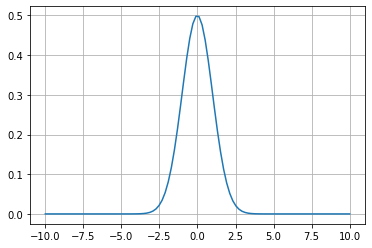

In [3]:
#plot the wavefunction
print(optd)
x_vals = np.linspace(-10,10,100)
y = [psi(x_a, optd) for x_a in x_vals]
v = [V(x_a) for x_a in x_vals]
comp_avg = avg_energy(optd, 10**5)
print(f"Minimized Energy: {comp_avg}")
true_energy = fifth_corrections()
print(f"True GS Energy: {true_energy}")
pdiff = 100*(true_energy -  comp_avg)/true_energy
print(f"Percent Difference: {pdiff}")
plt.plot(x_vals,y)
#plt.plot(x_vals,v)
plt.grid()
plt.show()

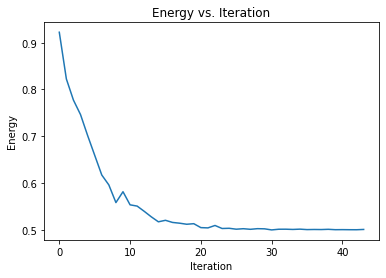

In [4]:
en = [avg_energy(x) for x in hist]
plt.plot(en)
plt.title("Energy vs. Iteration")
plt.ylabel("Energy")
plt.xlabel("Iteration")
plt.show()

In [5]:
#generating the data for a lambda vs ground state energy plot
lams5 = np.linspace(0, .2, 50)
start = [.5,.5,.5]
es5 = []
tes5 = []
for l in lams5:
    lam = l
    es5.append(avg_energy(grad_opt(start)[-1]))
    tes5.append(fifth_corrections())

Average Energy: 0.6040536692289477
All under tolerance


In [6]:
#generating the data for a lambda vs ground state energy plot
lams2 = np.linspace(0, .2, 50)
start = [.5,.5,.5]
es2 = []
tes2 = []
for l in lams2:
    lam = l
    es2.append(avg_energy(grad_opt(start)[-1]))
    tes2.append(second_corrections())

Average Energy: 0.6031530077515196
All under tolerance


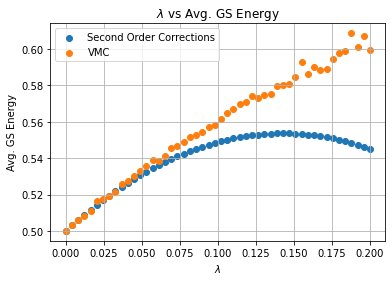

In [7]:
plt.scatter(lams2, tes2, label="Second Order Corrections")
plt.scatter(lams2, es2,label="VMC")
plt.title("$\lambda$ vs Avg. GS Energy")
plt.xlabel("$\lambda$")
plt.ylabel("Avg. GS Energy")
plt.grid()
plt.legend()
plt.show()

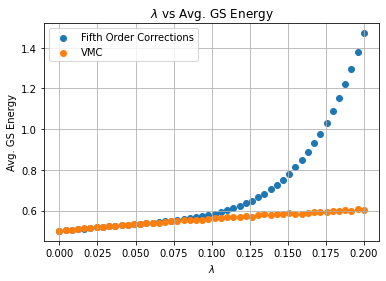

In [8]:
plt.scatter(lams5, tes5, label="Fifth Order Corrections")
plt.scatter(lams5, es5,label="VMC")
plt.title("$\lambda$ vs Avg. GS Energy")
plt.xlabel("$\lambda$")
plt.ylabel("Avg. GS Energy")
plt.grid()
plt.legend()
plt.show()

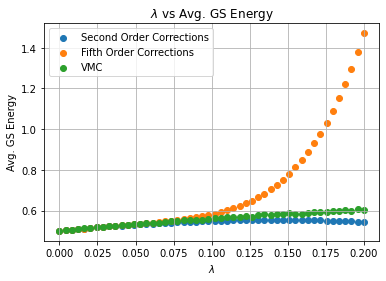

In [9]:
plt.scatter(lams2, tes2, label="Second Order Corrections")
plt.scatter(lams5, tes5, label="Fifth Order Corrections")
plt.scatter(lams5, es5,label="VMC")
plt.title("$\lambda$ vs Avg. GS Energy")
plt.xlabel("$\lambda$")
plt.ylabel("Avg. GS Energy")
plt.grid()
plt.legend()
plt.show()